# Explainable AI


## Worksheet 3: Anchors
---

---
### What are anchors?

Anchors provide a local rule explantion for a given observation which can potentially be applied predict the output for multiple similar observations. For further information on the topic and definitions, we refer students to the lecture slides and recordings for the XAI technique (Anchors).

Useful sources:

*   https://christophm.github.io/interpretable-ml-book/anchors.html
*   https://docs.seldon.io/projects/alibi/en/stable/index.html

---

---

### Today's problem

In this tutorial, we will look at applications of anchors, an explanability technique invented by [Ribeiro et al. (2018)](https://homes.cs.washington.edu/~marcotcr/aaai18.pdf) and use them in the context of lending decisions. We will use a Python package [Alibi](https://docs.seldon.io/projects/alibi/en/stable/overview/getting_started.html) and call the library to analyse local predictions of a logistic regression.

Remember, even though generalized additive models are widely considered to be transparent, once a number of considered features reaches a large number, it is hard to interpret your framework.

The dataset in this notebook comes from UCI Machine Learning Respository and can be found [here](https://archive.ics.uci.edu/ml/datasets/statlog+(german+credit+data)). Each row represents a loan application by a customer with the labels representing whether it was approved or rejected.


---


## Example


### Importing libraries & data

Similarly to the last work sheet, we need to install libraries, which are not by default in Google Colab.

In [20]:
!pip install alibi

Now, we can import the extra functionalities from relevant Python libraries.

In [21]:
import pandas as pd
import numpy as np
from alibi.explainers import AnchorTabular
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, cross_val_score
##from sklearn.metrics import classification_report, plot_confusion_matrix, accuracy_score
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix, accuracy_score
from google.colab import drive
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from alibi.utils.data import gen_category_map

To load the data, as usual, we need to connect Google colab to our google drive.

In [22]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [23]:
df = pd.read_csv("/content/drive/My Drive/XAI-Worksheets/german.data", sep=' ', header = None)
df

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,...,A121,67,A143,A152,2,A173,1,A192,A201,1
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,...,A121,22,A143,A152,1,A173,1,A191,A201,2
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,...,A121,49,A143,A152,1,A172,2,A191,A201,1
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,...,A122,45,A143,A153,1,A173,2,A191,A201,1
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,...,A124,53,A143,A153,2,A173,2,A191,A201,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,A14,12,A32,A42,1736,A61,A74,3,A92,A101,...,A121,31,A143,A152,1,A172,1,A191,A201,1
996,A11,30,A32,A41,3857,A61,A73,4,A91,A101,...,A122,40,A143,A152,1,A174,1,A192,A201,1
997,A14,12,A32,A43,804,A61,A75,4,A93,A101,...,A123,38,A143,A152,1,A173,1,A191,A201,1
998,A11,45,A32,A43,1845,A61,A73,4,A93,A101,...,A124,23,A143,A153,1,A173,1,A192,A201,2


Note, that our columns have no names. To make it more readable, we will add column names that best reflect the data dictionary attached to the dataset (german.doc file).

In [24]:
cols = ["Current_account", "Duration", "Credit_history", "Purpose", "Credit_amount", "Savings", "Employment_length", "Instalment_rate", "Personal_status", "Guarantors", "Time_at_address", "Property", "Age", "Instalment_plan", "Housing", "Existing_loans", "Employment", "Dependants", "Telephone", "Foreign_worker", "Label"]

df.columns = cols
df

,Current_account,Duration,Credit_history,Purpose,Credit_amount,Savings,Employment_length,Instalment_rate,Personal_status,Guarantors,...,Property,Age,Instalment_plan,Housing,Existing_loans,Employment,Dependants,Telephone,Foreign_worker,Label
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,...,A121,67,A143,A152,2,A173,1,A192,A201,1
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,...,A121,22,A143,A152,1,A173,1,A191,A201,2
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,...,A121,49,A143,A152,1,A172,2,A191,A201,1
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,...,A122,45,A143,A153,1,A173,2,A191,A201,1
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,...,A124,53,A143,A153,2,A173,2,A191,A201,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,A14,12,A32,A42,1736,A61,A74,3,A92,A101,...,A121,31,A143,A152,1,A172,1,A191,A201,1
996,A11,30,A32,A41,3857,A61,A73,4,A91,A101,...,A122,40,A143,A152,1,A174,1,A192,A201,1
997,A14,12,A32,A43,804,A61,A75,4,A93,A101,...,A123,38,A143,A152,1,A173,1,A191,A201,1
998,A11,45,A32,A43,1845,A61,A73,4,A93,A101,...,A124,23,A143,A153,1,A173,1,A192,A201,2


### Data processing

We will now go through the usual steps of inspecting and cleaning our data. The steps we take are the same as in the previous worksheets.

In [25]:
df.head()

,Current_account,Duration,Credit_history,Purpose,Credit_amount,Savings,Employment_length,Instalment_rate,Personal_status,Guarantors,...,Property,Age,Instalment_plan,Housing,Existing_loans,Employment,Dependants,Telephone,Foreign_worker,Label
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,...,A121,67,A143,A152,2,A173,1,A192,A201,1
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,...,A121,22,A143,A152,1,A173,1,A191,A201,2
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,...,A121,49,A143,A152,1,A172,2,A191,A201,1
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,...,A122,45,A143,A153,1,A173,2,A191,A201,1
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,...,A124,53,A143,A153,2,A173,2,A191,A201,2


In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Current_account    1000 non-null   object
 1   Duration           1000 non-null   int64 
 2   Credit_history     1000 non-null   object
 3   Purpose            1000 non-null   object
 4   Credit_amount      1000 non-null   int64 
 5   Savings            1000 non-null   object
 6   Employment_length  1000 non-null   object
 7   Instalment_rate    1000 non-null   int64 
 8   Personal_status    1000 non-null   object
 9   Guarantors         1000 non-null   object
 10  Time_at_address    1000 non-null   int64 
 11  Property           1000 non-null   object
 12  Age                1000 non-null   int64 
 13  Instalment_plan    1000 non-null   object
 14  Housing            1000 non-null   object
 15  Existing_loans     1000 non-null   int64 
 16  Employment         1000 non-null   object
 

#### **Question 1:**
Which of these features could potentially be perceived as a source of bias and/or discrimination?

#### **Question 2:**
How would you describe the quality of this data?

Next, let's relabel the data to have the outcomes in the form of 0s and 1s.

- Before: 1s represent "good customers" and 2s stand for "bad customers".
- After: 0s represent "good customers" and 1s stand for "bad customers".

In [27]:
df["Label"] = [0 if x  == 1 else 1 for x in df["Label"]]

Secondly, to use the logistic regression, we need to create dummy variables. Each column will correspond to N-1 categories instead of all N of them to avoid a dummy variable trap.

In [28]:
df = pd.get_dummies(df, drop_first=True)

Thirdly, we need to separate the training data from the testing set.

In [29]:
features = df.drop(columns = ["Label"])
labels = df["Label"]

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

Before we proceed, let's have a look at the training set as a sanity check.

In [30]:
X_train

,Duration,Credit_amount,Instalment_rate,Time_at_address,Age,Existing_loans,Dependants,Current_account_A12,Current_account_A13,Current_account_A14,...,Property_A124,Instalment_plan_A142,Instalment_plan_A143,Housing_A152,Housing_A153,Employment_A172,Employment_A173,Employment_A174,Telephone_A192,Foreign_worker_A202
29,60,6836,3,4,63,2,1,0,0,0,...,1,0,1,1,0,0,1,0,1,0
535,21,2319,2,1,33,1,1,0,1,0,...,0,0,1,0,0,0,1,0,0,0
695,6,1236,2,4,50,1,1,0,0,1,...,0,0,1,0,0,0,1,0,0,0
557,21,5003,1,4,29,2,1,0,0,1,...,0,0,0,1,0,0,1,0,1,0
836,12,886,4,2,21,1,1,0,0,1,...,0,0,1,1,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106,18,6458,2,4,39,2,2,0,0,1,...,1,0,0,1,0,0,0,1,1,0
270,18,2662,4,3,32,1,1,0,0,1,...,0,0,1,1,0,0,1,0,0,1
860,24,5804,4,2,27,2,1,0,0,1,...,0,0,1,1,0,0,1,0,0,0
435,12,1484,2,1,25,1,1,1,0,0,...,0,0,1,1,0,0,1,0,1,0


### Modelling

We will be using a linear logit model here.

In [31]:
clf = LogisticRegression(max_iter = 1000)
fitted_logreg = clf.fit(X_train, y_train)

Now, let's assess the model's performance.

The simple function below will be used to the test data to  check how predictive the classifier is.

Confusion Matrix:


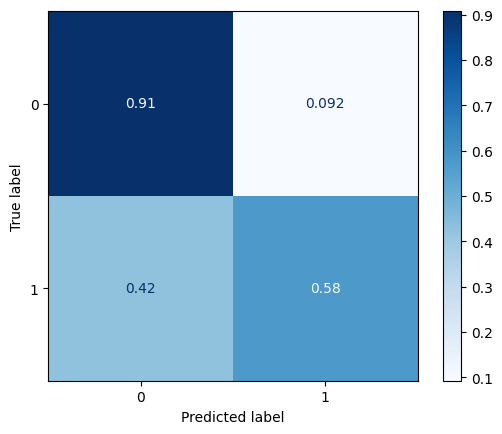

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.91      0.87       141
           1       0.72      0.58      0.64        59

    accuracy                           0.81       200
   macro avg       0.78      0.74      0.76       200
weighted avg       0.80      0.81      0.80       200



Done


In [35]:
def model_assessment(model, X, y):
    print("Confusion Matrix:")
    disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y, model.predict(X), normalize='true'))
    disp.plot(cmap=plt.cm.Blues)
    disp.title = "Normalized Confusion Matrix"
    plt.show()

    #produce a classification report
    print("Classification Report:")
    pred = model.predict(X)
    print(classification_report(y, pred))
    print('\n')
    print("Done")

model_assessment(fitted_logreg, X_test, y_test)

We are getting very good results for class 0 observations but the F-1 score for class 1 could definitely be improved!



#### **Question 3:**
What could be the root of this mediocre performance?

#### **Question 4:**
Discuss how both customers and a bank using this model could be affected if predictions for class 1 are much less accurate than class 0.

We will try two fix it using two approaches and pick the one that gives the best results:

*   Approach 1: Tuning our hyperparameters
*   Approach 2: Over/undersampling methods

Let's start with the first approach.
There is number of ways in which we can tune our hyperparameters, with the simplest being manual adjustments. In fact, this is what will be attempted below.

Confusion Matrix:


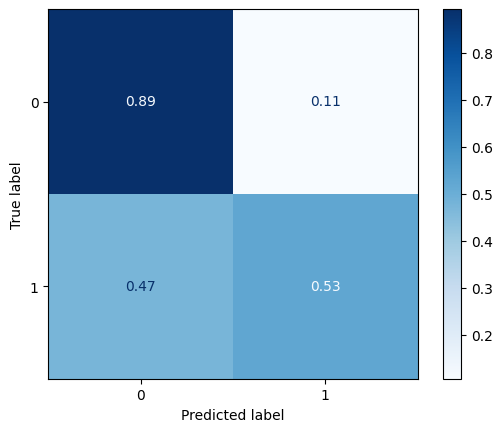

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.89      0.85       141
           1       0.67      0.53      0.59        59

    accuracy                           0.79       200
   macro avg       0.75      0.71      0.72       200
weighted avg       0.78      0.79      0.78       200



Done


In [36]:
# 1.1 Using L1 regularisation method instead of the default L2 in sklearn.
# To enable us to run L1 regularisation, we need to change our solver too (see sklearn documentation for more details).
# To avoid convergece issues, we can increase the max_iter parameter.
clf_1_1 = LogisticRegression(max_iter = 100000, penalty = "l1", solver = "liblinear")
fitted_logreg_1_1 = clf_1_1.fit(X_train, y_train)
model_assessment(fitted_logreg_1_1, X_test, y_test)

This did not help much in terms of overall performance, so let's stick with the default hyperparameter.

Confusion Matrix:


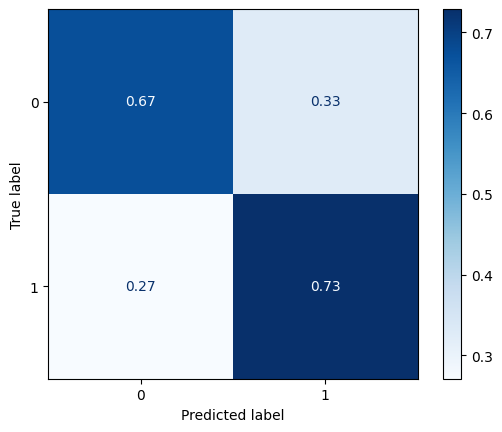

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.67      0.75       141
           1       0.48      0.73      0.58        59

    accuracy                           0.69       200
   macro avg       0.67      0.70      0.67       200
weighted avg       0.75      0.69      0.70       200



Done


In [37]:
# 1.2 Adjusting training weights associated with classes.
clf_1_2 = LogisticRegression(max_iter = 100000,  class_weight = 'balanced')
fitted_logreg_1_2 = clf_1_2.fit(X_train, y_train)
model_assessment(fitted_logreg_1_2, X_test, y_test)

This looks like an interesting result! On average, the classifier is worse, but the recall for class 1 is much better. Now, it is in fact better at dealing with class 1 than labelling class 0.

Next, let's turn to data adjustment methods.

Confusion Matrix:


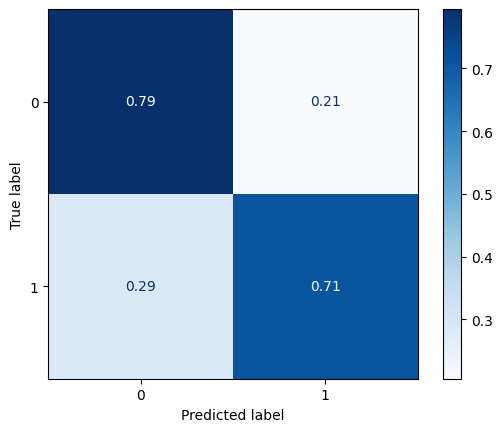

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.79      0.83       141
           1       0.59      0.71      0.65        59

    accuracy                           0.77       200
   macro avg       0.73      0.75      0.74       200
weighted avg       0.79      0.77      0.78       200



Done


In [38]:
# 2. SMOTE combined with undersampling of the majority class (a popular method in data science competitions!)
smote = SMOTE(sampling_strategy = 0.67, random_state = 404)
undersample = RandomUnderSampler(random_state = 202)
clf_2 = LogisticRegression(max_iter = 100000)

# We can use a pipeline approach to combine the sampling and modelling steps in one line.
steps = [('smote', smote), ('undersample', undersample), ('clf_2', clf_2)]
pipeline = Pipeline(steps=steps).fit(X_train, y_train)

model_assessment(pipeline, X_test, y_test)

This seems like the best approach to improving our model! We managed to create a classifier that yields good performance across both classes and seems much more balanced on multiple fronts as compared to the initial attempt.

### Application of anchors

Let's now look at individual predictions and discuss how anchors can help us with explaining the model's behaviour.

To begin with, we need to pick some observations from the test set.
We will be constructing anchors for those instances.
For instance, we can pick 10 last observations.


In [39]:
indices = X_test.index.tolist()[-10:]

Let's print the table with the features for these 10 observations...

In [40]:
data_anchor = X_test.loc[indices,]
data_anchor

,Duration,Credit_amount,Instalment_rate,Time_at_address,Age,Existing_loans,Dependants,Current_account_A12,Current_account_A13,Current_account_A14,...,Property_A124,Instalment_plan_A142,Instalment_plan_A143,Housing_A152,Housing_A153,Employment_A172,Employment_A173,Employment_A174,Telephone_A192,Foreign_worker_A202
948,18,1533,4,1,43,1,2,0,0,1,...,0,0,1,1,0,1,0,0,0,0
829,48,6681,4,4,38,1,2,1,0,0,...,1,0,1,0,1,0,1,0,1,0
656,12,888,4,4,41,1,2,1,0,0,...,0,0,0,1,0,1,0,0,0,0
199,18,4297,4,3,40,1,1,1,0,0,...,1,0,1,1,0,0,0,1,1,0
213,30,1908,4,4,66,1,1,0,1,0,...,0,0,1,1,0,0,0,1,1,0
408,24,3235,3,2,26,1,1,0,0,1,...,0,0,1,1,0,0,0,1,1,0
332,60,7408,4,2,24,1,1,1,0,0,...,0,0,1,1,0,0,0,1,0,0
208,24,6568,2,2,21,1,1,0,0,0,...,0,1,0,1,0,1,0,0,0,0
613,24,3632,1,4,22,1,1,0,0,0,...,0,0,0,0,0,0,1,0,0,1
78,54,9436,2,2,39,1,2,0,0,1,...,0,0,1,1,0,1,0,0,0,0


...and now their predicted labels.

In [41]:
labels_anchor = y_test[indices]
labels_anchor

948    1
829    0
656    1
199    1
213    1
408    0
332    1
208    0
613    0
78     0
Name: Label, dtype: int64

Once we have the data, we can run the anchors.
To do it, we need follow a number of steps:

1. Define a function that will be called to predict a label, this prediction will later be scrutinised with anchors.
2. Define a list with feature names.
3. Define what outcomes we have inside all categorical columns. (optional but advised)
4. Initialise the algorithm.
5. Fit the anchors to your training set.
6. Get the prediction.
7. Get the local explanation.

In [42]:
# 1.
predict_fn = lambda x: clf_2.predict(x)

# We can also define here a function that, once called, can give us the probabilities
# associated with an instance being class 0 or 1 according to the model.
# Below, this function will be utilised to get more insight about the predictions.
prob_fn = lambda x: clf_2.predict_proba(x)

# 2.
feature_names = X_train.columns.tolist()

# 3.
# We can do it using a function from the package.
categorical_feats = X_train.dtypes[X_train.dtypes != "int64"].index.tolist()
category_map = gen_category_map(X_train, categorical_columns = categorical_feats)

# Specify that the first category for all one-hot encoded variables
#  (previously 0) will now be "No" and the second (previously 1) "Yes".
for key in category_map.keys():
    category_map[key] = ["No", "Yes"]

# 4.
explainer = AnchorTabular(predict_fn, feature_names, categorical_names = category_map, seed = 2)

# 5.
# We need to discretize the ordinal features (i.e. any column where the order matters, for example income or age).
# We will be also setting the seed for reproductability.
# It is also advised to convert our dataframe to a numpy array with the package.
explainer.fit(X_train.to_numpy(), disc_perc = [25, 50, 75], seed = 2)

# Once we are done with steps 1-5, we can now focus on individual examples and produce
# anchors in a loop for all observations we are interested in.
for i in range(0, data_anchor.shape[0]):

    # 6.
    # We also need to apply .to_numpy() here to shape the data to a form that the library wants.
    print('Observation number:', i+1)
    instance_0_pred = explainer.predictor(data_anchor.to_numpy()[i].reshape(1, -1))[0]
    print('Prediction: ', instance_0_pred)

    predicted_probabilities = prob_fn(data_anchor.to_numpy()[i].reshape(1, -1))
    print('Probability of class 0: ', np.round(predicted_probabilities[0][0], 2))
    print('Probability of class 1: ', np.round(predicted_probabilities[0][1], 2))

    # 7.
    explanation = explainer.explain(data_anchor.to_numpy()[i], threshold=0.95)
    print('Anchor: %s' % (' AND '.join(explanation.anchor)))
    print('Precision: %.2f' % explanation.precision)
    print('Coverage: %.2f' % explanation.coverage)
    print('---')

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid

Observation number: 1
Prediction:  0
Probability of class 0:  0.72
Probability of class 1:  0.28
Anchor: Current_account_A14 = Yes AND Duration <= 18.00
Precision: 0.96
Coverage: 0.22
---
Observation number: 2
Prediction:  1
Probability of class 0:  0.39
Probability of class 1:  0.61


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid

Anchor: Current_account_A14 = No AND Duration > 24.00 AND Property_A124 = Yes AND Current_account_A12 = Yes
Precision: 1.00
Coverage: 0.03
---
Observation number: 3
Prediction:  1
Probability of class 0:  0.33
Probability of class 1:  0.67


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid

Anchor: Current_account_A14 = No AND Instalment_plan_A143 = No AND Credit_history_A34 = No AND Instalment_rate > 3.00 AND Purpose_A43 = No AND Savings_A65 = No
Precision: 0.96
Coverage: 0.03
---
Observation number: 4
Prediction:  1
Probability of class 0:  0.43
Probability of class 1:  0.57


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid

Anchor: Current_account_A14 = No AND Employment_A174 = Yes AND Credit_history_A34 = No AND Purpose_A41 = No AND Instalment_rate > 3.00 AND Credit_amount > 4154.50
Precision: 1.00
Coverage: 0.01
---
Observation number: 5
Prediction:  0
Probability of class 0:  0.87
Probability of class 1:  0.13


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid

Anchor: Current_account_A13 = Yes AND Employment_length_A75 = Yes AND Housing_A152 = Yes
Precision: 0.98
Coverage: 0.01
---
Observation number: 6
Prediction:  0
Probability of class 0:  0.76
Probability of class 1:  0.24
Anchor: Current_account_A14 = Yes AND Personal_status_A92 = No
Precision: 0.99
Coverage: 0.29
---
Observation number: 7
Prediction:  1
Probability of class 0:  0.03
Probability of class 1:  0.97


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid

Anchor: Current_account_A14 = No AND Duration > 24.00 AND Employment_length_A72 = Yes AND Existing_loans <= 1.00
Precision: 1.00
Coverage: 0.02
---
Observation number: 8
Prediction:  1
Probability of class 0:  0.23
Probability of class 1:  0.77


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid

Anchor: Current_account_A14 = No AND Credit_amount > 4154.50 AND Credit_history_A34 = No AND Age <= 27.00 AND Savings_A65 = No AND Personal_status_A93 = No
Precision: 0.98
Coverage: 0.01
---
Observation number: 9
Prediction:  0
Probability of class 0:  0.54
Probability of class 1:  0.46
Anchor: Purpose_A41 = Yes AND Guarantors_A103 = Yes
Precision: 0.96
Coverage: 0.00
---
Observation number: 10
Prediction:  0
Probability of class 0:  0.76
Probability of class 1:  0.24
Anchor: Current_account_A14 = Yes AND Purpose_A41 = Yes
Precision: 0.99
Coverage: 0.05
---


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid

*Note: As generating Anchors is stochastic, your generated anchors may be different to the interpretation below.*

We have our anchors now!

As an example, let's analyse the anchor for observation number 1. The condition generated there - "Current_account_A14 = Yes AND Duration <= 18" - can be translated to "the applicant has neither a current nor a savings account with the bank". If our classification model was to make decisions, it would classify a customer for who the statement above is true as class 0 (i.e. reject their loan application) in 97% of all cases, regardless of any other information we have about the individuals. The probability that the rule applies to the samples from the training set is 22%.


#### **Question 5:**
Do the anchors indicate that our model is behaving as expected? What features seem to mostly drive the individual predictions?

#### **Question 6:**
Do the generated rules suggest that our model can discriminate on the basis of any personal characteristics or can be accused of being biased?

#### **Question 7:**
Do any of those anchors apply to an extend which is large enough so that we could say the rules are approximately global?

*Hint:*
*   *Precision of 95 % = predictions on instances where the anchor holds (i.e. the rules based on the features apply) will be the same as the explained prediction at least 95% of the time*

*   *Coverage of 50 % = the anchor (i.e. the generated set of rules) applies to 50% of samples generated from the training set*

*In other words, "the conditions encapsulated in the rules hold for 50% of the samples, and where they apply, the observations will be predicted to belong to the same class as the original prediction based on the supplied data point in 95%+ of cases."*




Let's try to simplify some of those anchors.
For example, let's pick observation number 8.

In [43]:
# We can specify the maximum length of our anchor.
explanation = explainer.explain(data_anchor.to_numpy()[7], threshold=0.95, max_anchor_size = 3)
print('Anchor: %s' % (' AND '.join(explanation.anchor)))
print('Precision: %.2f' % explanation.precision)
print('Coverage: %.2f' % explanation.coverage)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid

Anchor: Current_account_A14 = No AND Credit_amount > 4154.50 AND Instalment_plan_A143 = No
Precision: 0.81
Coverage: 0.03


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


Precision of 82% is not terrible, but a coverage of 0.03% certainly is. Based off these results this rule applies to a very small subset and not very well. Likely, other instances in the training set can better capture model behavior for classification.

---

## Assignment 3


1.   Discuss when applying anchors for local explanations may be a better idea than using SHAP.
2.   Explain why some anchors are longer than others and what could long anchors signal.  
3.   Outline disadvantages of using anchors.
4.   Retrain the Logistic model with a perturbed version of the training set. Isolate the observations where Current_account_A14 = Yes, and then add to this smaller training set just 10 observations where Current_account_A14 = No, thus creating a training set with a feature value bias. Generate 10 anchors on the origional test set, using a new anchor explainer trained on our new model and new training set, and comment on the differences between the returned anchors and those seen previously. Try to explain why you see specific differences between the anchors.
5.   Consider the biased model first trained in the workbook ```fitted_logreg``` which did not take advantage of under and over sampling methods. For this question you will generate 10 anchors for the biased model. Recreate the origional training and test sets as done for the origional ```fitted_logreg``` model and use them for creating an Anchor explainer. When generating the 10 anchors, only generate anchors for instances in the test set where the classificaiton is 0 (majority class). What do you notice about the rate of precision and coverage, and why might these metrics be problematic given the biased performance of ```fitted_logreg```? What would a coverage of 1 mean? What would precision of 1 mean?
6.   Write a paragraph for a non-technical audience explaining the model above (```clf_2```) made a prediction for the first observation in the testing set. Base your answer on the output of anchors and estimated parameters of the logistic regression model. You will need to find the anchor and produce regression outputs yourself using Python. Be sure to justify your investigation process by explaining your sequential steps taken and what they signify or reveal.

